In [33]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt


In [34]:
df = pd.read_csv('merged_df.csv', index_col=None)

# remove outliers
# remove absence_range, finalResult, 
df = df.drop(['absences_range', 'finalResult'], axis=1)
df = df[df['absences'] < 20]

### Columns pre selection removing G1 and G2

In [35]:
#  transform all non object to object type
df[['Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel','freetime', 'goout', 
    'Dalc', 'Walc', 'health']] = df[['Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel','freetime', 'goout', 'Dalc', 'Walc', 'health']].astype('object') 

columns_cat = df[['school', 'sex', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health']]

continue_cols = df[['age','absences', 'G1']]

# cocat in a new dataframe
df_cat = pd.concat([columns_cat, continue_cols], axis=1)
# make copy to use in the next cell


### Columns transformation and encoding

In [48]:
X = df_cat
ct = make_column_transformer(
      (MinMaxScaler(),
       make_column_selector(dtype_include=np.number)),
      (OneHotEncoder(),
       make_column_selector(dtype_include=object)))

# Apply the column transformer to the data
X_preprocessed = ct.fit_transform(X)  

# Create a new dataframe with the preprocessing applied
feature_names = ct.get_feature_names_out()
new_df = pd.DataFrame(X_preprocessed, columns=feature_names)

df_cat_outliers = new_df.copy()


### Train test and split

In [37]:
# train test split
X = new_df
y = df['G3']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
#y_train.groupby(y_train).count().plot(kind='bar'),

X_test.describe()

,minmaxscaler__age,minmaxscaler__absences,minmaxscaler__G1,onehotencoder__school_GP,onehotencoder__school_MS,onehotencoder__sex_F,onehotencoder__sex_M,onehotencoder__address_R,onehotencoder__address_U,onehotencoder__famsize_GT3,...,onehotencoder__Walc_1,onehotencoder__Walc_2,onehotencoder__Walc_3,onehotencoder__Walc_4,onehotencoder__Walc_5,onehotencoder__health_1,onehotencoder__health_2,onehotencoder__health_3,onehotencoder__health_4,onehotencoder__health_5
count,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,...,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000
mean,0.251401,0.223426,0.583333,0.735294,0.264706,0.534314,0.465686,0.235294,0.764706,0.656863,...,0.343137,0.196078,0.235294,0.147059,0.078431,0.112745,0.122549,0.205882,0.161765,0.397059
std,0.172862,0.237963,0.157834,0.442262,0.442262,0.500048,0.500048,0.425226,0.425226,0.475925,...,0.475925,0.398005,0.425226,0.355036,0.269511,0.317059,0.328726,0.405340,0.369141,0.490492
min,0.000000,0.000000,0.263158,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.142857,0.000000,0.473684,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.285714,0.157895,0.578947,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.428571,0.315789,0.684211,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,0.714286,0.947368,0.947368,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Function to train and fine tune a model

In [7]:
def evaluate_models(X_train, X_test, y_train, y_test):

    # Create pipelines for each model
    knn_pipeline = Pipeline(steps=[
        ('regressor', KNeighborsRegressor())
    ])

    dt_pipeline = Pipeline(steps=[
        ('regressor', DecisionTreeRegressor())
    ])

    linear_pipeline = Pipeline(steps=[
        ('regressor', LinearRegression())
    ])

    # Define hyperparameter search spaces for each pipeline
    knn_params = {'regressor__n_neighbors': [3, 5, 7, 9, 11],
                  'regressor__weights': ['uniform', 'distance'],
                  'regressor__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                  'regressor__leaf_size': [10, 20, 30, 40, 50],
                  'regressor__p': [1, 2]}

    dt_params = {'regressor__criterion': ['friedman_mse', 'squared_error', 'poisson', 'absolute_error'],
                 'regressor__splitter': ['best', 'random'],
                 'regressor__max_depth': [2, 3, 4, 5],
                 'regressor__min_samples_split': [2, 3, 4, 5],
                 'regressor__min_samples_leaf': [1, 2, 3, 4, 5]}

    # Create a dictionary containing all the pipelines and their corresponding hyperparameter search spaces
    pipelines = {
        'knn': (knn_pipeline, knn_params),
        'dt': (dt_pipeline, dt_params),
        'linear': (linear_pipeline, {})
    }

    # Create lists to store the pipeline names, MSE values, and R-squared values
    pipeline_names = []
    mse_values = []
    r2_values = []

    # Perform grid search for each pipeline
    for pipeline_name, (pipeline, param_grid) in pipelines.items():
        print(f"Performing grid search for pipeline: {pipeline_name}")
        grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        y_pred = grid_search.predict(X_test)

        # Compute metrics
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Add pipeline name, MSE value, and R-squared value to the lists
        pipeline_names.append(pipeline_name)
        mse_values.append(mse)
        r2_values.append(r2)

        print(f"Best parameters for {pipeline_name}: {grid_search.best_params_}")
        print(f"Mean squared error: {mse:.3f}")
        print(f"R-squared: {r2:.3f}")
    return grid_search, y_pred, pipeline_names, mse_values, r2_values

def print_model_evaluation(model, X_train, X_test, y_train, y_test):
    # print the best model
    print(f'best model is: {model.best_estimator_}')
    
    # mse and r2 on train and test
    print('Mean squared error on train:', mean_squared_error(y_train, model.predict(X_train)))
    print('Mean squared error on test: %.2f' % mean_squared_error(y_test, model.predict(X_test)))
    print('--------------------------------------')
    print('Coefficient of determination train: %.2f' % r2_score(y_train, model.predict(X_train)))
    print('Coefficient of determination test: %.2f' % r2_score(y_test, model.predict(X_test)))

## Light Features (No G1 and G2)

In [8]:
eval_ligh = evaluate_models(X_train, X_test, y_train, y_test)

Performing grid search for pipeline: knn
Best parameters for knn: {'regressor__algorithm': 'ball_tree', 'regressor__leaf_size': 20, 'regressor__n_neighbors': 11, 'regressor__p': 2, 'regressor__weights': 'uniform'}
Mean squared error: 12.228
R-squared: 0.178
Performing grid search for pipeline: dt
Best parameters for dt: {'regressor__criterion': 'poisson', 'regressor__max_depth': 3, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__splitter': 'best'}
Mean squared error: 3.791
R-squared: 0.745
Performing grid search for pipeline: linear
Best parameters for linear: {}
Mean squared error: 4.985
R-squared: 0.665


best model is: Pipeline(steps=[('regressor', LinearRegression())])
Mean squared error on train: 4.725411315392451
Mean squared error on test: 4.99
--------------------------------------
Coefficient of determination train: 0.69
Coefficient of determination test: 0.66


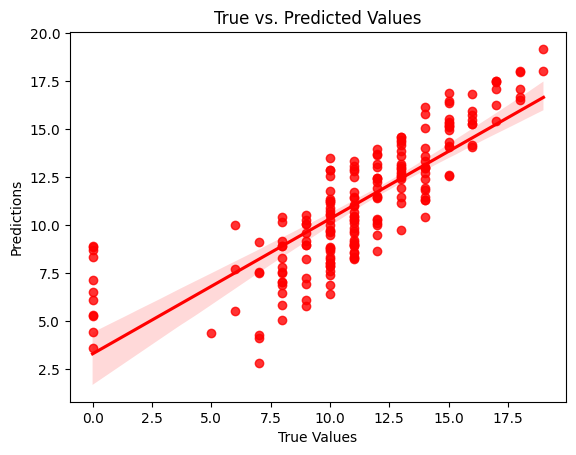

In [9]:
print_model_evaluation(eval_ligh[0], X_train, X_test, y_train, y_test)

# Create scatter plot with regression line using Seaborn
sns.regplot(x=y_test, y=eval_ligh[1], color='red')

# Add labels and title using Matplotlib
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs. Predicted Values')

# Display the plot
plt.show()

## Adding G1

In [10]:
#  transform all non object to object type
df[['Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel','freetime', 'goout', 
    'Dalc', 'Walc', 'health']] = df[['Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel','freetime', 'goout', 'Dalc', 'Walc', 'health']].astype('object') 

columns_cat = df[['school', 'sex', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health']]

continue_cols = df[['age','absences', 'G1']]

# cocat in a new dataframe
df_cat = pd.concat([columns_cat, continue_cols], axis=1)

# Create a column transformer
X = df_cat
ct = make_column_transformer(
      (MinMaxScaler(),
       make_column_selector(dtype_include=np.number)),
      (OneHotEncoder(),
       make_column_selector(dtype_include=object)))

# Apply the column transformer to the data
X_preprocessed = ct.fit_transform(X)  

# Create a new dataframe with the preprocessing applied
feature_names = ct.get_feature_names_out()
new_df = pd.DataFrame(X_preprocessed, columns=feature_names)


# train test split
X = new_df
y = df['G3']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

eval_ligh = evaluate_models(X_train, X_test, y_train, y_test)


Performing grid search for pipeline: knn
Best parameters for knn: {'regressor__algorithm': 'ball_tree', 'regressor__leaf_size': 20, 'regressor__n_neighbors': 11, 'regressor__p': 2, 'regressor__weights': 'uniform'}
Mean squared error: 12.228
R-squared: 0.178
Performing grid search for pipeline: dt
Best parameters for dt: {'regressor__criterion': 'poisson', 'regressor__max_depth': 3, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__splitter': 'best'}
Mean squared error: 3.791
R-squared: 0.745
Performing grid search for pipeline: linear
Best parameters for linear: {}
Mean squared error: 4.985
R-squared: 0.665


best model is: Pipeline(steps=[('regressor', LinearRegression())])
Mean squared error on train: 4.725411315392451
Mean squared error on test: 4.99
--------------------------------------
Coefficient of determination train: 0.69
Coefficient of determination test: 0.66


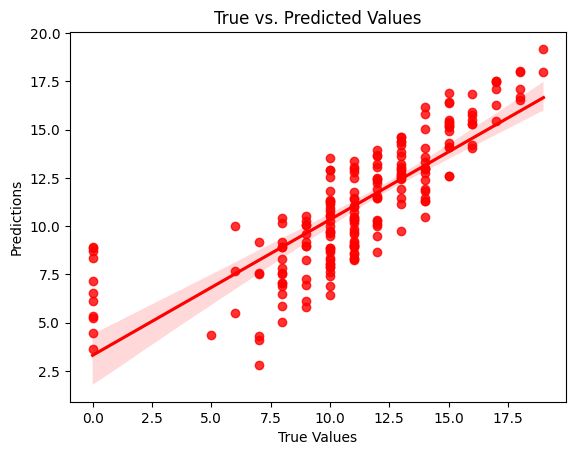

In [11]:
print_model_evaluation(eval_ligh[0], X_train, X_test, y_train, y_test)

# Create scatter plot with regression line using Seaborn
sns.regplot(x=y_test, y=eval_ligh[1], color='red')

# Add labels and title using Matplotlib
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs. Predicted Values')

# Display the plot
plt.show()

## Adding G2

In [12]:
#  transform all non object to object type
df[['Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel','freetime', 'goout', 
    'Dalc', 'Walc', 'health']] = df[['Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel','freetime', 'goout', 'Dalc', 'Walc', 'health']].astype('object') 

columns_cat = df[['school', 'sex', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health']]

continue_cols = df[['age','absences', 'G2']]

# cocat in a new dataframe
df_cat = pd.concat([columns_cat, continue_cols], axis=1)

# Create a column transformer
X = df_cat
ct = make_column_transformer(
      (MinMaxScaler(),
       make_column_selector(dtype_include=np.number)),
      (OneHotEncoder(),
       make_column_selector(dtype_include=object)))

# Apply the column transformer to the data
X_preprocessed = ct.fit_transform(X)  

# Create a new dataframe with the preprocessing applied
feature_names = ct.get_feature_names_out()
new_df = pd.DataFrame(X_preprocessed, columns=feature_names)

# train test split
X = new_df
y = df['G3']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

eval_ligh = evaluate_models(X_train, X_test, y_train, y_test)


Performing grid search for pipeline: knn
Best parameters for knn: {'regressor__algorithm': 'kd_tree', 'regressor__leaf_size': 10, 'regressor__n_neighbors': 11, 'regressor__p': 2, 'regressor__weights': 'uniform'}
Mean squared error: 12.093
R-squared: 0.187
Performing grid search for pipeline: dt
Best parameters for dt: {'regressor__criterion': 'poisson', 'regressor__max_depth': 4, 'regressor__min_samples_leaf': 5, 'regressor__min_samples_split': 2, 'regressor__splitter': 'best'}
Mean squared error: 3.061
R-squared: 0.794
Performing grid search for pipeline: linear
Best parameters for linear: {}
Mean squared error: 3.438
R-squared: 0.769


best model is: Pipeline(steps=[('regressor', LinearRegression())])
Mean squared error on train: 2.1312942035670357
Mean squared error on test: 3.44
--------------------------------------
Coefficient of determination train: 0.86
Coefficient of determination test: 0.77


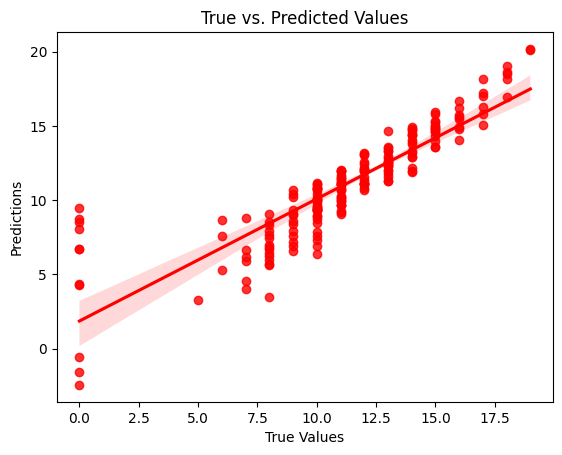

In [13]:
print_model_evaluation(eval_ligh[0], X_train, X_test, y_train, y_test)

# Create scatter plot with regression line using Seaborn
sns.regplot(x=y_test, y=eval_ligh[1], color='red')

# Add labels and title using Matplotlib
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs. Predicted Values')

# Display the plot
plt.show()

## Adding G1 and G2

In [14]:
#  transform all non object to object type
df[['Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel','freetime', 'goout', 
    'Dalc', 'Walc', 'health']] = df[['Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel','freetime', 'goout', 'Dalc', 'Walc', 'health']].astype('object') 

columns_cat = df[['school', 'sex', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health']]

continue_cols = df[['age','absences', 'G1','G2']]

# cocat in a new dataframe
df_cat = pd.concat([columns_cat, continue_cols], axis=1)

# Create a column transformer
X = df_cat
ct = make_column_transformer(
      (MinMaxScaler(),
       make_column_selector(dtype_include=np.number)),
      (OneHotEncoder(),
       make_column_selector(dtype_include=object)))

# Apply the column transformer to the data
X_preprocessed = ct.fit_transform(X)  

# Create a new dataframe with the preprocessing applied
feature_names = ct.get_feature_names_out()
new_df = pd.DataFrame(X_preprocessed, columns=feature_names)

# train test split
X = new_df
y = df['G3']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

eval_ligh = evaluate_models(X_train, X_test, y_train, y_test)


Performing grid search for pipeline: knn
Best parameters for knn: {'regressor__algorithm': 'kd_tree', 'regressor__leaf_size': 30, 'regressor__n_neighbors': 9, 'regressor__p': 1, 'regressor__weights': 'uniform'}
Mean squared error: 11.497
R-squared: 0.227
Performing grid search for pipeline: dt
Best parameters for dt: {'regressor__criterion': 'friedman_mse', 'regressor__max_depth': 3, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__splitter': 'best'}
Mean squared error: 3.845
R-squared: 0.742
Performing grid search for pipeline: linear
Best parameters for linear: {}
Mean squared error: 3.327
R-squared: 0.776


best model is: Pipeline(steps=[('regressor', LinearRegression())])
Mean squared error on train: 2.0972509442806833
Mean squared error on test: 3.33
--------------------------------------
Coefficient of determination train: 0.86
Coefficient of determination test: 0.78


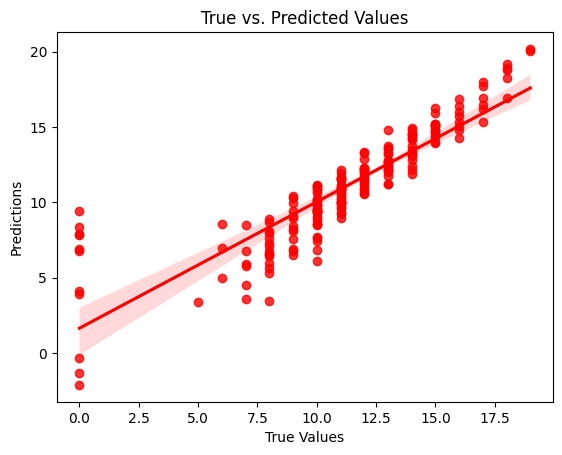

In [15]:
print_model_evaluation(eval_ligh[0], X_train, X_test, y_train, y_test)

# Create scatter plot with regression line using Seaborn
sns.regplot(x=y_test, y=eval_ligh[1], color='red')

# Add labels and title using Matplotlib
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs. Predicted Values')

# Display the plot
plt.show()

### Testing Polynomial Features


In [16]:
# import the class polynomial features
from sklearn.preprocessing import PolynomialFeatures


# Create polynomial features up to degree 2
poly = PolynomialFeatures(degree=2)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)

In [23]:
X_poly_test.shape, X_poly_train.shape,

((204, 5050), (813, 5050))

In [34]:
eval_poly = evaluate_models(X_poly_train, X_poly_test, y_train, y_test)

Performing grid search for pipeline: knn
Best parameters for knn: {'regressor__algorithm': 'ball_tree', 'regressor__leaf_size': 20, 'regressor__n_neighbors': 11, 'regressor__p': 1, 'regressor__weights': 'uniform'}
Mean squared error: 11.682
R-squared: 0.215
Performing grid search for pipeline: dt


In [ ]:
print_model_evaluation(eval_ligh[0], X_poly_train, X_poly_test, y_train, y_test)

# Create scatter plot with regression line using Seaborn
sns.regplot(x=y_test, y=eval_ligh[1], color='red')

# Add labels and title using Matplotlib
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs. Predicted Values')

# Display the plot
plt.show()

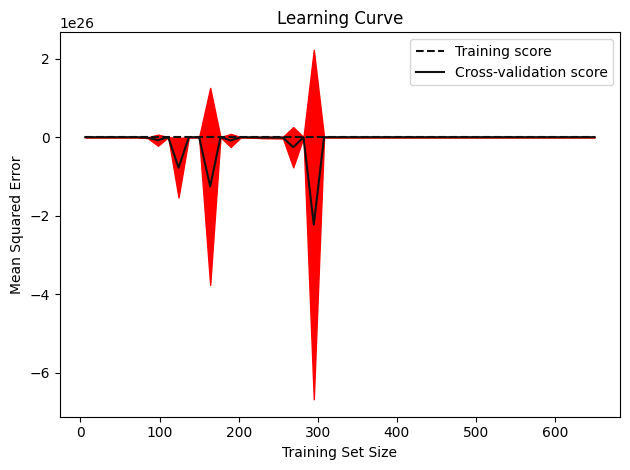

In [44]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LinearRegression

# Define variables and parameters
model = LinearRegression()
cv = 5
scoring = 'neg_mean_squared_error'
train_sizes = np.linspace(0.01, 1.0, 50)

# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(
    estimator=model,
    X=X_train,
    y=y_train,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    train_sizes=train_sizes,
    random_state=42
)

# Calculate means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.plot(train_sizes, train_mean, '--', color="#111111", label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="red")
plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Mean Squared Error")
plt.legend(loc="best")
plt.tight_layout()
plt.show()


## Outliers removal

In [62]:
# Calculate the IQR
q1, q3 = np.percentile(df_cat_outliers, [15, 85])
iqr = q3 - q1

# remove outliers
df_cat_no_out = df_cat_outliers[~((df_cat_outliers < (q1 - 1.5 * iqr)) |(df_cat_outliers > (q3 + 1.5 * iqr))).any(axis=1)]

print(df_cat_no_out.shape)

(1017, 98)


In [63]:
# Train test split
X = df_cat_no_out
y = df['G3']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

eval = evaluate_models(X_train, X_test, y_train, y_test)


Performing grid search for pipeline: knn
Best parameters for knn: {'regressor__algorithm': 'ball_tree', 'regressor__leaf_size': 20, 'regressor__n_neighbors': 11, 'regressor__p': 2, 'regressor__weights': 'uniform'}
Mean squared error: 12.228
R-squared: 0.178
Performing grid search for pipeline: dt
Best parameters for dt: {'regressor__criterion': 'poisson', 'regressor__max_depth': 3, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__splitter': 'best'}
Mean squared error: 3.791
R-squared: 0.745
Performing grid search for pipeline: linear
Best parameters for linear: {}
Mean squared error: 4.942
R-squared: 0.668


best model is: Pipeline(steps=[('regressor', LinearRegression())])
Mean squared error on train: 4.782710639606396
Mean squared error on test: 4.94
--------------------------------------
Coefficient of determination train: 0.68
Coefficient of determination test: 0.67


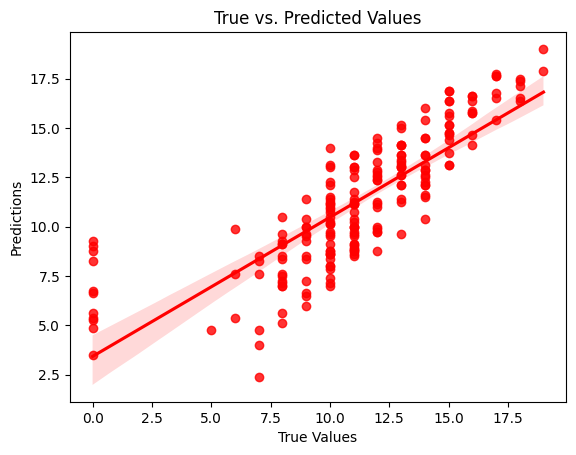

In [64]:
print_model_evaluation(eval[0], X_train, X_test, y_train, y_test)

# Create scatter plot with regression line using Seaborn
sns.regplot(x=y_test, y=eval[1], color='red')

# Add labels and title using Matplotlib
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs. Predicted Values')

# Display the plot
plt.show()